In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [14]:
train_feats = pd.read_csv('../../3_feature_eng/output/train_feats_double_corr.csv')
train_score = pd.read_csv('../../0_data/train_scores.csv')

# train_feats_first10min = pd.read_csv('../../feature_eng/output/train_double_corr_first_10min_786feats.csv')
# train_feats_second10min = pd.read_csv('../../feature_eng/output/train_double_corr_second_10min_786feats.csv')
# train_feats = train_feats.merge(train_feats_first10min, on='id', how='left')
# train_feats = train_feats.merge(train_feats_second10min, on='id', how='left')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
train_feats = train_feats[~train_feats['id'].isin(['3e10785d'])]
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [16]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute",
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies"
# "IWD", "idle", "cursor_visits"
# "intro_punctuation", "body_punctuation", "conclusion_punctuation"
# "intro_aggs", "body_aggs", "conclusion_aggs"

endings_to_keep = ["count_bursts", "word_sent_parag_agg", "intro_punctuation", "body_punctuation", "conclusion_punctuation"
 "intro_aggs", "body_aggs", "conclusion_aggs", "time_feat", "cursor_visits"]
endings_to_keep += ["id"]

dir_to_save = "svr25"
stratification = True
n_jobs = 4
noise = True
data_augmentation = False

try:
    os.mkdir(dir_to_save)
except:
    print('Already exists')
    sys.exit()

# cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]
cols_to_keep = [col for col in train_feats.columns if any(ending in col for ending in endings_to_keep) or col in ['id', 'score']]
# cols_to_keep = manual_list + ['id', 'score']

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

414


In [17]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [18]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [19]:
def data_augmentation(x, y, pct=0.75, scale=0.05):
    # Determine the number of rows to create
    num_rows = x.shape[0]
    num_new_rows = int(num_rows * pct)

    # Randomly select rows from the original array
    indices = np.random.choice(np.arange(num_rows), size=num_new_rows)
    new_rows_x = x[indices]

    # Add Gaussian noise to each numerical column
    for col in range(new_rows_x.shape[1]):
        noise = np.random.normal(loc=0.0, scale=scale, size=num_new_rows)
        new_rows_x[:, col] += new_rows_x[:, col] * noise

    # Append the new rows to the original array
    x = np.concatenate([x, new_rows_x])

    # Do the same for y
    y = y.reset_index(drop=True)
    new_rows_y = y.loc[indices]
    y = pd.concat([y, new_rows_y], ignore_index=True)

    return x, y

In [20]:
def svr_calc_OOF(x_train, y_train, x_valid, noise=False, data_augmentation=False):
        
    imputer = SimpleImputer(strategy='median')
    scaler = MinMaxScaler(feature_range=(-1, 1))

    x_train = imputer.fit_transform(x_train)
    x_train = scaler.fit_transform(x_train)

    x_valid = imputer.transform(x_valid)
    x_valid = scaler.transform(x_valid)

    if data_augmentation:
        x_train, y_train = data_augmentation(x_train, y_train, pct=0.75, scale=0.05)
    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)

    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    model.fit(x_train, y_train.values.ravel())

    valid_predict = model.predict(x_valid)

    # Return OOFs
    return valid_predict

In [21]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

iterations = 5
n_splits = 5

for i in range(iterations):

    if stratification:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats, score_transformed)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = svr_calc_OOF(X_train, y_train, X_valid, noise=noise, data_augmentation=data_augmentation)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

    # else:
    #     kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    #     j = 0
    #     for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
            
    #         X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
    #         X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

    #         valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, noise=noise, data_augmentation=data_augmentation)

    #         OOF_SCORE[valid_idx] += valid_predict / iterations
    #         j+=1

In [22]:
print('OOF metric SVR = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric SVR = 0.63383


In [23]:
import pickle

with open(f'{dir_to_save}/OOF_base_svr.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE, f)

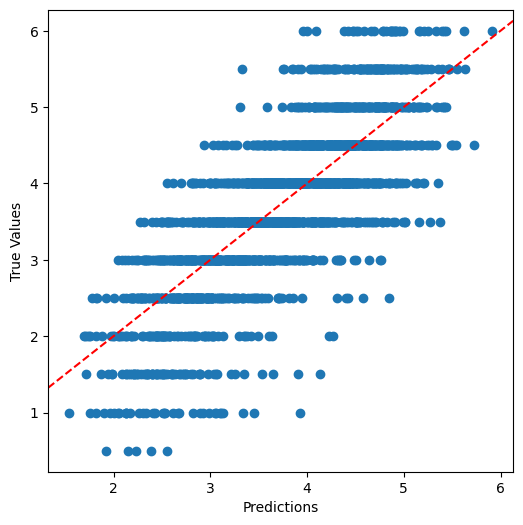

In [24]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()